In [1]:
!pip install sentence_transformers
!pip install samplesizelib

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import time

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
    
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

from samplesizelib.linear.statistical import LikelihoodRatioEstimator
from samplesizelib.linear.models import RegressionModel

from torchvision import datasets
from torchvision import transforms

# Homework
**Task** : Использовать модель для векторизации предложений из семинара. На основе полученных векторов решить задачу сентимент анализа для выборки Twitter (задача бинарной классификации). В качестве модели рассмотреть логистическую регрессию. Рекомендуется использовать модель Perceptron с третьего семинара, а также функцию ошибки torch.nn.BCELoss. 

# Данные


In [43]:
data = pd.read_csv("data/Sentiment Analysis Dataset.csv", error_bad_lines=False)

data.head(5)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [44]:
x, y = data.SentimentText[::100], data.Sentiment[::100] # for now we will take only 1% of original dataset due to computation difficulties

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train.shape, x_test.shape

((12629,), (3158,))

In [45]:
# Sentences to vectors

vectorizer = SentenceTransformer('LaBSE', device='cuda', cache_folder='vectorizer_params/')
X_train = vectorizer.encode(x_train.to_list())
X_test = vectorizer.encode(x_test.to_list())

Y_train = y_train.to_numpy().astype(int)
Y_test = y_test.to_numpy().astype(int)

# save to files

np.save(file='data/train_vectors_full', arr=X_train)
np.save(file='data/test_vectors_full', arr=X_test)

np.save(file='data/target_train_full', arr=Y_train)
np.save(file='data/target_test_full', arr=Y_test)

In [94]:
X_train = np.load("data/train_vectors_full.npy")
X_test = np.load("data/test_vectors_full.npy")

Y_train = np.load('data/target_train_full.npy')
Y_test = np.load('data/target_test_full.npy')

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((12629, 768), (3158, 768), (12629,), (3158,))

In [95]:
Y_train.dtype, Y_test.dtype

(dtype('int64'), dtype('int64'))

По-хорошему мы должны были бы использовать K-Fold, чтобы получить объективную оценку качества и отобрать гиперпараметры, а затем измериить качество работы на тесте. Однако, мы имеем дело с достаточно большим датасетом (1.2 М train и 0.3 M тест). K-Fold на выборке такого размера даже при небольшой архитектуре займет много времени. Поэтому мы будем использовать обычный train/val split. В силу размера, оценка качества и при таком подходе должна быть достаточно объективной.

In [96]:
x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, Y_train, test_size=0.1)


x_train_fold = torch.Tensor(x_train_fold)
x_val_fold = torch.Tensor(x_val_fold)
y_train_fold = torch.FloatTensor(y_train_fold)
y_val_fold = torch.FloatTensor(y_val_fold)

traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
valdata = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

x_train_fold.shape, x_val_fold.shape

(torch.Size([11366, 768]), torch.Size([1263, 768]))

## Model side

В качестве модели рассмотрим перцептрон из семинара 3.

In [114]:
INPUT_DIM = 768

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [116]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=INPUT_DIM, num_layers=0, 
                 hidden_dim=100, output_dim=1, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [130]:
from IPython.display import clear_output


def testing_binary(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=51200)

    pred = []
    real = []
    for x, y in generator:
        x = x.to(device)

        pred.extend((model(x).squeeze() >= 0).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)


def trainer(model, dataset, loss_function, optimizer, epochs, val_data=None):
    loss_history = []
    acc_history = []
    
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=51200, 
                                              shuffle=True)
        
        model.train()
        for x, y in generator:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.data.cpu().numpy())
        
        model.eval()
        acc, _ = testing_binary(model, val_data)
        acc_history.append(acc)
        clear_output(True)

        # print intermediate results
        plt.subplots(1, 2)
        
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
    
        plt.subplot(1, 2, 2)
        plt.plot(acc_history)
        
        time.sleep(0.1)
        plt.pause(0.0001)

В силу опять же большой выборки, неплохо иметь априорное представление о том, что мы получим на выходе перед hyperparameter tuning. Для этого мы воспользуемся baseline моделью, гиперпараметры которой выбраны умозрительно.

In [131]:
baseline_model = Perceptron(hidden_dim=200, num_layers=5, p=0.1).to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-4)

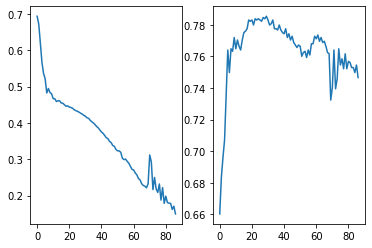

KeyboardInterrupt: 

In [132]:
baseline_model.train()

trainer(baseline_model,
        traindata,
        torch.nn.BCEWithLogitsLoss(),
        optimizer,
        epochs=1000,
        val_data=valdata)

In [180]:
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.FloatTensor(Y_test))

acc, report = testing_binary(baseline_model, test_dataset)

In [181]:
acc

0.7577580747308423